In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys

import csv
import json
import time
import types, copy, pprint
import logging 

from datetime import datetime

if './src' not in sys.path:
    print(f"insert ./src")
    sys.path.insert(0, './src')
print(sys.path)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
import shutil
import getpass
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torchinfo import summary
print(torch.__version__)

pd.options.display.width = 132
pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# print("1- '%x_%X'               : ",time.strftime('%x_%X'))
# print("2- '%X.%f'               : ",datetime.now().strftime('%X.%f'))
# print("3- '%X %x %Z'            : ",time.strftime('%X %x %Z'))
# print("4- '%D-%X.%f'            : ",datetime.now().strftime('%D-%X.%f'))
# print("5- '%Y-%m-%d %H:%M:%S.%f': ",datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'))
# print("6- '%Y%m%d_%H%M%S'       : ",datetime.now().strftime('%Y%m%d_%H%M%S'))
# print("7- '%Y_%m_%d_%H:%M:%S'   : ",datetime.now().strftime('%Y_%m_%d_%H:%M:%S'))
print("7- '%Y_%m_%d_%H:%M:%S'   : ",datetime.now().strftime('%Y%m%d_%H%M%S'))

timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
print(' Timestamp: ','./tmp/sql_cohort'+'_'+timestamp+'.txt')

logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

insert ./src
['./src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages']
2.2.1+cu118
7- '%Y_%m_%d_%H:%M:%S'   :  20240404_234818
 Timestamp:  ./tmp/sql_cohort_2024_04_04_23:48:18.txt


In [3]:
from dev_code import SNNLoss

In [4]:
def _get_device():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = f"{device}:{torch.cuda.current_device()}"
    print("Running on:", device, torch.cuda.get_device_name(), torch.cuda.current_device())
    return device

current_device = _get_device()
print(f"Current device is : {current_device}")

Running on: cuda:0 Quadro GV100 0
Current device is : cuda:0


## SNNL

In [5]:
# from snnl import SNNLoss
_ = torch.manual_seed(42)

In [6]:
snnl = SNNLoss(temperature=1.0)

 Build SNNLoss dfrom NOTEBOOK
 Building SNNLoss from NOTEBOOK
    SNNLoss _init()_    -- mode: classifier was found in SNNLoss._supported_modes --   is unsupervised: False
    SNNLoss _init()_    -- primary_criterion: CrossEntropyLoss()
    SNNLoss _init()_    -- unsupervised :     False
    SNNLoss _init()_    -- use_annealing :    False
    SNNLoss _init()_    -- sample_size :      1


In [ ]:
features = torch.rand((4, 2))

In [312]:
features = torch.Tensor([[1.0, 1.0],
                         [2.0, 2.0],
                         [-1.0, -1.0],
                         [-2.0, -2.0]]
                       )
features = torch.Tensor([[2.0, 2.0],
                         [-2.0, -2.0]])
features = torch.Tensor([[0.02, 0.02],
                         [0.1, 0.1],
                         [1.02, 1.02],
                         [2.00, 2.00]])
features

tensor([[0.0200, 0.0200],
        [0.1000, 0.1000],
        [1.0200, 1.0200],
        [2.0000, 2.0000]])

In [313]:
labels = torch.Tensor([[0.0],[0.0],[0.0],[0.0]])
# labels = torch.Tensor([[0.0],[0.0]])
# labels = torch.Tensor([[0.0],[0.0],[0.0]])
labels.shape

torch.Size([4, 1])

In [321]:
snnl.sample_size = 1
snnl.temperature = 2.2

In [322]:
snnl.distance_matrix = snnl.pairwise_cosine_distance(features)
snnl.distance_matrix

snnl.pairwise_distance_matrix = snnl.normalize_distance_matrix(features=features, distance_matrix=snnl.distance_matrix, device='cpu')
snnl.pairwise_distance_matrix

tensor([[ 5.9605e-08,  5.9605e-08,  0.0000e+00,  5.9605e-08],
        [ 5.9605e-08,  5.9605e-08,  0.0000e+00,  5.9605e-08],
        [ 0.0000e+00,  0.0000e+00, -1.1921e-07,  0.0000e+00],
        [ 5.9605e-08,  5.9605e-08,  0.0000e+00,  5.9605e-08]])

tensor([[0., 1., 1., 1.],
        [1., 0., 1., 1.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.]])

In [323]:
snnl.pick_probability = snnl.compute_sampling_probability(snnl.pairwise_distance_matrix)
snnl.pick_probability

tensor([[0.0000, 0.3333, 0.3333, 0.3333],
        [0.3333, 0.0000, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.0000, 0.3333],
        [0.3333, 0.3333, 0.3333, 0.0000]])

In [324]:
snnl.summed_masked_pick_probability = snnl.mask_sampling_probability(labels, snnl.pick_probability, device='cpu')

In [325]:
snnl.masking_matrix
snnl.masked_pick_probability
snnl.summed_masked_pick_probability
-torch.log(snnl.stability_epsilon + snnl.summed_masked_pick_probability)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

tensor([0., 0., 0., 0.])

tensor([11.5129, 11.5129, 11.5129, 11.5129])

In [326]:
snnl.final =  torch.mean( -torch.log(snnl.stability_epsilon + snnl.summed_masked_pick_probability))
snnl.final

tensor(11.5129)

In [327]:
x = []
y = []

for t in range(1,+50,+1):
    # if t == 0:
    #     continue
    snnl.temperature = t
    snnl.distance_matrix = snnl.pairwise_cosine_distance(features)
    snnl.pairwise_distance_matrix = snnl.normalize_distance_matrix(features=features, distance_matrix=snnl.distance_matrix, device='cpu')
    snnl.pick_probability = snnl.compute_sampling_probability(snnl.pairwise_distance_matrix)
    snnl.summed_masked_pick_probability = snnl.mask_sampling_probability(labels, snnl.pick_probability, device='cpu')
    snnl.final =  torch.mean( -torch.log(snnl.stability_epsilon + snnl.summed_masked_pick_probability))
    x.append(t)
    y.append(snnl.final)

49

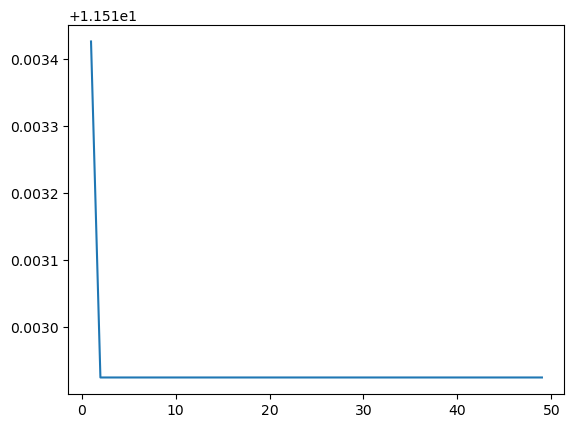

In [328]:
len(x)
plt.plot(x,y)

In [329]:
x = []
y = []


for t in np.arange(1.0,+5.0,+0.01):
    # if t == 0:
    #     continue
    snnl.temperature = t
    snnl.distance_matrix = snnl.pairwise_cosine_distance(features)
    snnl.pairwise_distance_matrix = snnl.normalize_distance_matrix(features=features, distance_matrix=snnl.distance_matrix, device='cpu')
    snnl.pick_probability = snnl.compute_sampling_probability(snnl.pairwise_distance_matrix)
    snnl.summed_masked_pick_probability = snnl.mask_sampling_probability(labels, snnl.pick_probability, device='cpu')
    snnl.final =  torch.mean( -torch.log(snnl.stability_epsilon + snnl.summed_masked_pick_probability))
    x.append(t)
    y.append(snnl.final)

400

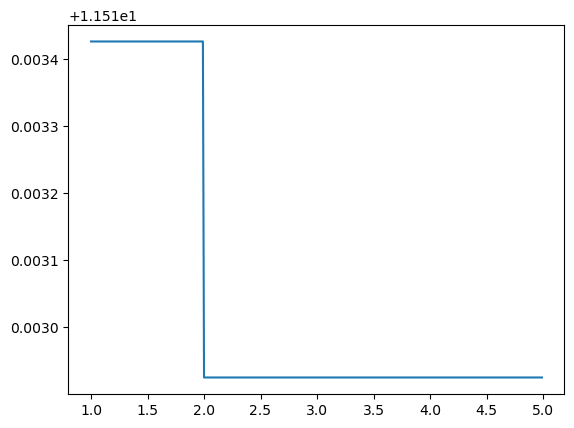

In [330]:
len(x)
plt.plot(x,y)

In [60]:
# self.distance_matrix = self.pairwise_cosine_distance(features=value)

# self.pairwise_distance_matrix = self.normalize_distance_matrix(features=value, 
#                                                                distance_matrix=self.distance_matrix, 
#                                                                device=model.device)

# self.pick_probability = self.compute_sampling_probability(self.pairwise_distance_matrix)

# self.summed_masked_pick_probability = self.mask_sampling_probability(labels, 
#                                                                      self.pick_probability, 
#                                                                      device=model.device)

# snnl = torch.mean( -torch.log(self.stability_epsilon + self.summed_masked_pick_probability))

In [18]:
1/0.092200
1/50.

10.845986984815617

0.02

## e**-t

In [15]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams['text.usetex'] = True

In [16]:
x = []
y1 = []
y2 = []
y3 = []
y4 = []
y5 = []
y6 = []
diff = 0.2
dist1 = 0.01
dist2 = 1.00
temp  = 5.0
for temp in  np.arange(1,20,0.1):
    # temp1 = np.exp(-(dist1))
    temp2 = np.exp(-(dist1/temp))
    # temp3 = np.exp(-(dist2))
    temp4 = np.exp(-(dist2/temp))
    temp5 = temp2/temp4
    temp6 = -np.log(temp5)
    # temp3 = -np.log(np.exp(-ep)/np.exp(-(ep+diff)))
    # temp3 = 1.0 / ((1.0 + ep) ** 0.55)
    x.append(temp)
    # y1.append(temp1)
    y2.append(temp2)
    # y3.append(temp3)
    y4.append(temp4)
    y5.append(temp5)
    y6.append(temp6)


# plt.plot(x,y1,color='b')
plt.plot(x,y2,   '--b', )
# plt.plot(x,y3,color='r')
plt.plot(x,y4,   '--r')
plt.plot(x,y5,   '--g')
plt.plot(x,y6,   '-c')
# plt.legend([r'e^{dist}{T}','b','c',"d"])
ax.set_title(r'\TeX\ is Number $\displaystyle\sum_{n=1}^\infty'
             r'\frac{-e^{i\pi}}{2^n}$!', fontsize=16, color='r')
# df = pd.DataFrame(dict(
    # x=x,
    # y=y1,
    # moa=pd.concat([treated_wells["MOA"], treatments["MOA"]]),
    # batch=pd.concat([treated_wells["Plate"].apply(lambda x: x.split("_")[0]), treatments["Batch"]]),
    # compound=pd.concat([treated_wells["Compound"], treatments["Compound"]]),
    # correct=pd.concat([treated_wells["nsc"],treatments["nsc"]]),
    # level=pd.concat([treated_wells["level"],treatments["level"]])
# ))

# plt.figure()
# sb.lmplot(x,y1, fit_reg=False, palette="hls")

NameError: name 'ax' is not defined

Error in callback <function _draw_all_if_interactive at 0x7f43748e1760> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpby31fs8g 7047aaa5111e4d8dda9c547b5b45d07c.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./7047aaa5111e4d8dda9c547b5b45d07c.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.9 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmpby31fs8g/7047aaa5111e4d8dda9c547b5b45d07c.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpu5ivg50f 7047aaa5111e4d8dda9c547b5b45d07c.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./7047aaa5111e4d8dda9c547b5b45d07c.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.9 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmpu5ivg50f/7047aaa5111e4d8dda9c547b5b45d07c.log.




<Figure size 640x480 with 1 Axes>

In [52]:
y1[0], y1[-1]
y2

(0.9900498337491681, 0.9900498337491681)

[0.9900498337491681,
 0.9950124791926823,
 0.9966722160545233,
 0.9975031223974601,
 0.9980019986673331,
 0.9983347214509387,
 0.9985724484938566,
 0.9987507809245809,
 0.9988895059442793,
 0.999000499833375,
 0.9990913221888589,
 0.9991670137924583,
 0.9992310650129109,
 0.9992859693270274,
 0.9993335555061811,
 0.9993751952718163,
 0.9994119376823444,
 0.9994445987368581,
 0.9994738226903856,
 0.9995001249791693,
 0.9995239228844999,
 0.9995455578355891,
 0.999565311895566,
 0.9995834201268338,
 0.9996000799893344,
 0.9996154585703999,
 0.9996296982082685,
 0.9996429209107757,
 0.9996552318599922,
 0.9996667222160499,
 0.9996774713783809,
 0.9996875488230391,
 0.9996970156060145,
 0.9997059256012962,
 0.9997143265267252,
 0.9997222607988971,
 0.9997297662494491,
 0.9997368767282647,
 0.99974362261389,
 0.999750031247396,
 0.9997561273027574,
 0.9997619331043265,
 0.9997674689000131,
 0.9997727530972171,
 0.999777802467307,
 0.9997826323234296,
 0.9997872566756243,
 0.9997916883665486

## annealing

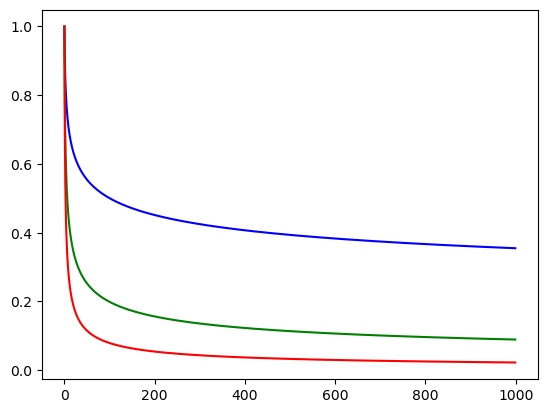

In [17]:
x = []
y1 = []
y2 = []
y3 = []

for ep in  range(1000):
    temp1 = 1.0 / ((1.0 + ep) ** 0.15)
    temp2 = 1.0 / ((1.0 + ep) ** 0.35)
    temp3 = 1.0 / ((1.0 + ep) ** 0.55)
    x.append(ep)
    y1.append(temp1)
    y2.append(temp2)
    y3.append(temp3)

plt.plot(x,y1,color='b')
plt.plot(x,y2,color='green')
plt.plot(x,y3,color='r')